In [10]:
import ee
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AVHEtk5zv9K8XwF7iPM65OfJJ9SrWMiB8zEvipkAmijpdD6AzIeuRIJmu6k

Successfully saved authorization token.


In [11]:
### methane data import 

import pandas as pd
import json
import folium
import geopandas as gpd

In [12]:
# Download the methane metadata from https://earth.jpl.nasa.gov/emit/data/data-portal/Greenhouse-Gases/

methane_data = "Methane Metadata.json"
df = gpd.read_file(methane_data)

In [13]:
df.head()

,Concentration Uncertainty (ppm m),Integrated Methane Enhancement (kg CH4),Integrated Methane Enhancement - Positive (kg CH4),Integrated Methane Enhancement Uncertainty (kg CH4),L1B Radiance Download,Latitude of max concentration,Longitude of max concentration,Max Plume Concentration (ppm m),Scene FID,UTC Time Observed,map_endtime,style,plume_complex_count,geometry
0,401,2930.29,3522.030220,3482.64,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,22.338843,56.401937,2164,emit20220811t042630,2022-08-11T04:26:30+00:00,2022-08-11T04:26:31+00:00,"{'color': 'white', 'fillOpacity': 0, 'maxZoom'...",NaN,"POLYGON ((56.40492 22.36568, 56.40546 22.36568..."
1,401,2930.29,3522.030220,3482.64,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,22.338843,56.401937,2164,emit20220811t042630,2022-08-11T04:26:30+00:00,2022-08-11T04:26:31+00:00,"{'color': 'red', 'fillOpacity': 0, 'maxZoom': ...",NaN,POINT Z (56.40194 22.33884 0.00000)
2,354,391.92,505.011760,545.12,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,34.892068,41.142430,1747,emit20220814t051412,2022-08-14T05:14:12+00:00,2022-08-14T05:14:13+00:00,"{'color': 'white', 'fillOpacity': 0, 'maxZoom'...",1.0,"POLYGON ((41.14758 34.89668, 41.14812 34.89668..."
3,354,391.92,505.011760,545.12,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,34.892068,41.142430,1747,emit20220814t051412,2022-08-14T05:14:12+00:00,2022-08-14T05:14:13+00:00,"{'color': 'red', 'fillOpacity': 0, 'maxZoom': ...",2.0,POINT Z (41.14243 34.89207 0.00000)
4,406,56443.49,64649.193589,77594.43,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,39.360606,53.765060,5964,emit20220815t042838,2022-08-15T04:28:38+00:00,2022-08-15T04:28:39+00:00,"{'color': 'white', 'fillOpacity': 0, 'maxZoom'...",3.0,"POLYGON ((53.43132 39.42703, 53.43186 39.42703..."


In [14]:
#df[:1]

### Add Methane Plumes & Land Cover Layer

In [16]:
# Import the MODIS land cover collection.
lc = ee.ImageCollection('MODIS/006/MCD12Q1')

# Import the MODIS land surface temperature collection.
# lst = ee.ImageCollection('MODIS/006/MOD11A1')

# Import the USGS ground elevation image.
# elv = ee.Image('USGS/SRTMGL1_003')



# Initial date of interest (inclusive).
i_date = '2017-01-01'

# Final date of interest (exclusive).
f_date = '2020-01-01'

# Selection of appropriate bands and dates for LST.
# lst = lst.select('LST_Day_1km', 'QC_Day').filterDate(i_date, f_date)


In [17]:
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
      tiles=map_id_dict['tile_fetcher'].url_format,
      attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name=name,
      overlay=True,
      control=True
    ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer


In [19]:

# Select a specific band and dates for land cover.
lc_img = lc.select('LC_Type1').filterDate(i_date).first()

# Set visualization parameters for land cover.
lc_vis_params = {
    'min': 1,'max': 17,
    'palette': ['05450a','086a10', '54a708', '78d203', '009900', 'c6b044',
                'dcd159', 'dade48', 'fbff13', 'b6ff05', '27ff87', 'c24f44',
                'a5a5a5', 'ff6d4c', '69fff8', 'f9ffa4', '1c0dff']
}

# Create a map.
lat, lon = 20.59, 78.96
my_map = folium.Map(location=[lat, lon], zoom_start=4)


    

# Add the land cover to the map object.
my_map.add_ee_layer(lc_img, lc_vis_params, 'Land Cover')

# Add a layer control panel to the map.
# my_map.add_child(folium.LayerControl())


## Add MEthane Plumes into the map
for _, r in df.iterrows():
    location = [r['Latitude of max concentration'], r['Longitude of max concentration']]
    folium.Marker(location, popup = f'Scene FID:{r["Scene FID"]}').add_to(my_map)

    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=1)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'red'})
    folium.Popup(r['Max Plume Concentration (ppm m)']).add_to(geo_j)
    geo_j.add_to(my_map)

# Display the map.
display(my_map)

In [27]:
colors_palette = {
'Evergreen Needleleaf Forests':'05450a',
'Evergreen Broadleaf Forests':'086a10',
'Deciduous Needleleaf Forests':'54a708',
'Deciduous Broadleaf Forests':'78d203',
'Mixed Forests':'009900',
'Closed Shrublands':'c6b044',
'Open Shrublands':'dcd159',
'Woody Savannas':'dade48',
'Savannas':'fbff13',
'Grasslands':'b6ff05',
'Permanent Wetlands':'27ff87',
'Croplands':'c24f44',
'Urban and Built-up Lands':'a5a5a5',
'Cropland/Natural Vegetation Mosaics':'ff6d4c',
'Permanent Snow and Ice':'69fff8',
'Barren':'f9ffa4',
'Water Bodies':'1c0dff'
}

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Evergreen Needleleaf Forests


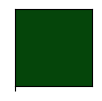

--------------------------------------------------
Evergreen Broadleaf Forests


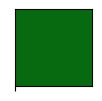

--------------------------------------------------
Deciduous Needleleaf Forests


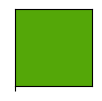

--------------------------------------------------
Deciduous Broadleaf Forests


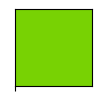

--------------------------------------------------
Mixed Forests


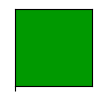

--------------------------------------------------
Closed Shrublands


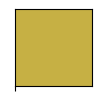

--------------------------------------------------
Open Shrublands


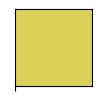

--------------------------------------------------
Woody Savannas


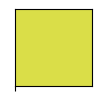

--------------------------------------------------
Savannas


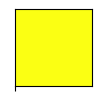

--------------------------------------------------
Grasslands


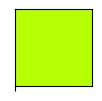

--------------------------------------------------
Permanent Wetlands


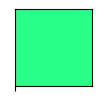

--------------------------------------------------
Croplands


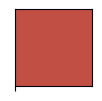

--------------------------------------------------
Urban and Built-up Lands


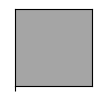

--------------------------------------------------
Cropland/Natural Vegetation Mosaics


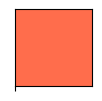

--------------------------------------------------
Permanent Snow and Ice


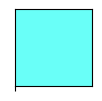

--------------------------------------------------
Barren


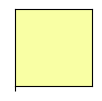

--------------------------------------------------
Water Bodies


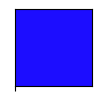

--------------------------------------------------


In [32]:
for name, color in colors_palette.items():
    print(name)
    flatui = ['#{}'.format(color)]
    plt.show(sns.palplot(sns.color_palette(flatui)))
    print('-'*50)